In [54]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split


public_data = pd.read_csv('extracted_public_data.csv')
public_data = public_data.dropna()
mapping = {
    "precision": {"single": 0, "double": 1},
    "backend": {"GPU": 0, "CPU": 1}
}
remapped_public_data = public_data.replace(mapping)
remapped_public_data['normalized_threshold'] = (1/8) * np.log2(remapped_public_data['threshold'])

features = pd.read_csv('qasm_features_scaled.csv')

match_col_test = remapped_public_data.columns[0]
match_col_features = features.columns[0]

inputs = pd.merge(
    remapped_public_data, 
    features, 
    left_on=match_col_test, 
    right_on=match_col_features, 
    how='left'
)
inputs = inputs.drop(columns=[match_col_features])



y = public_data['fidelity']
inputs = inputs.drop(columns=['circuit', "threshold", 'fidelity', 'expected_runtime_sec'])

inputs.to_csv('inputs.csv', index=False)


xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)


C:\Users\percy\AppData\Local\Temp\ipykernel_19964\1740817754.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  remapped_public_data = public_data.replace(mapping)


In [55]:
x_train, x_test, y_train, y_test = train_test_split(inputs, y, test_size=0.2, random_state=42)




In [56]:
xgb_model.fit(x_train, y_train) 


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:27:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:linear'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [57]:
y_pred = xgb_model.predict(x_test)

In [58]:
mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.006443691069634743


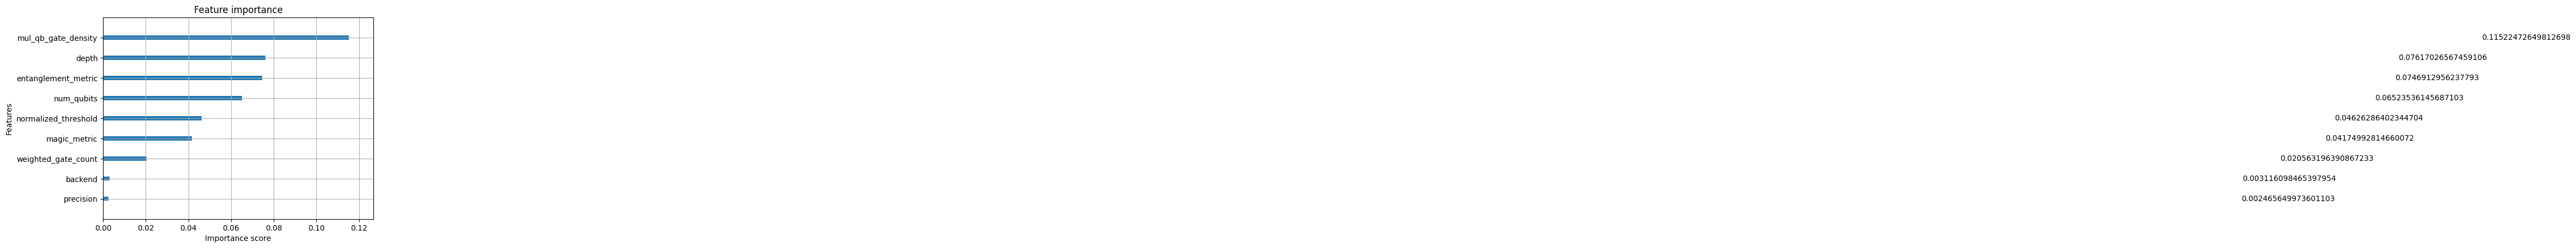

In [ ]:


plot_importance(xgb_model, importance_type='gain')
plt.show()

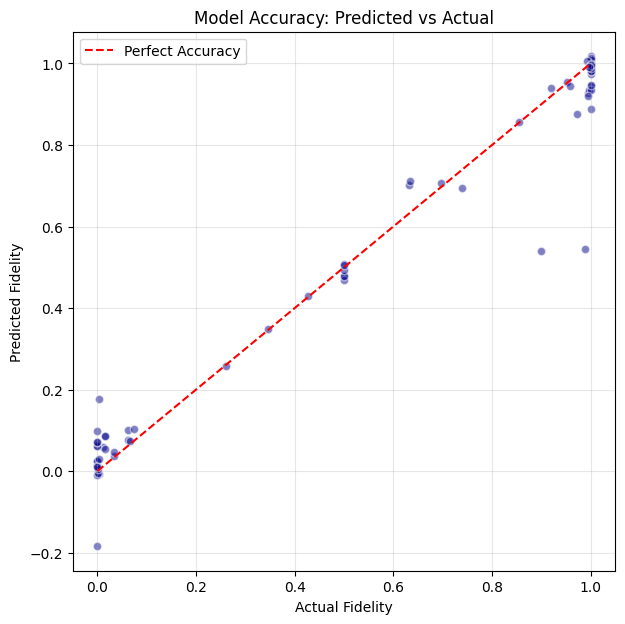

In [60]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.5, color='darkblue', edgecolors='white')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Accuracy')
plt.xlabel('Actual Fidelity')
plt.ylabel('Predicted Fidelity')
plt.title('Model Accuracy: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
xgb_model.save_model("fidelity_xgboost.json")